# SNR Experiment Runner (PRISMA/EnMAP)

Run the eight-case SNR experiment (cases A-H) for PRISMA or EnMAP scenes via `scripts.snr_experiment`. Each case toggles destriping, PCA order, aggregation method, and notch filtering to probe how processing choices impact $SNR(\lambda) = L(\lambda)/\sigma(\lambda)$. The notebook simply orchestrates repeated CLI calls and collates the resulting diagnostics under `notebooks/outputs/<sensor>/<scene_id>/`.


## Prerequisites

- Install the dependencies bundled in `environment.min.yml` (scientific Python stack plus GDAL).
- Stage PRISMA `.he5`/`.zip` files or EnMAP VNIR/SWIR/`METADATA.XML` inputs so the CLI can read them.
- Adjust the scene configuration dictionaries to reflect your local paths, ROIs, spectral windows, destriping strength, and PCA arguments.


In [1]:
import os
import sys
import subprocess
from pathlib import Path
from datetime import datetime
from typing import Iterable, Optional

from IPython.display import Markdown, display

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")
os.environ["PYTHONPATH"] = str(REPO_ROOT)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
PYTHON = sys.executable
DEFAULT_OUTDIR = NOTEBOOK_ROOT / 'outputs'
DEFAULT_OUTDIR.mkdir(parents=True, exist_ok=True)


display(Markdown(
    f"**Notebook root**: `{REPO_ROOT}`  \
     **Python**: `{PYTHON}`  \
     **PYTHONPATH**: `{os.environ['PYTHONPATH']}`"
))

**Notebook root**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`       **Python**: `/home/esivla/miniconda3/envs/hygasMF/bin/python`       **PYTHONPATH**: `/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas`

In [2]:
def run_snr_experiment(
    sensor: str,
    inputs: Iterable[str],
    roi: Optional[str] = None,
    bands: Optional[str] = None,
    cases: Optional[str] = None,
    disable_notch: bool = False,
    extra_args: Optional[Iterable[str]] = None,
    outdir: Optional[str] = None,
):
    """Invoke the CLI for a single scene and return the completed process."""

    target_outdir = Path(outdir) if outdir else DEFAULT_OUTDIR
    target_outdir.mkdir(parents=True, exist_ok=True)

    cmd = [
        PYTHON,
        "-m",
        "scripts.snr_experiment",
        "--sensor",
        sensor,
        "--input",
    ]
    cmd.extend(str(path) for path in inputs)
    if roi:
        cmd.extend(["--roi", roi])
    if bands:
        cmd.extend(["--bands", bands])
    if cases:
        cmd.extend(["--cases", cases])
    if disable_notch:
        cmd.append("--disable-notch")
    cmd.extend(["--outdir", str(target_outdir)])
    if extra_args:
        cmd.extend(str(arg) for arg in extra_args)

    display(Markdown(f"**Running**: `{' '.join(cmd)}`"))
    start = datetime.now()
    result = subprocess.run(cmd, capture_output=True, text=True, env=os.environ.copy())
    duration = datetime.now() - start
    status = "success" if result.returncode == 0 else f"failed (code {result.returncode})"

    display(Markdown(f"- Status: **{status}** in {duration.total_seconds():.1f}s"))
    if result.stdout:
        display(Markdown(f"<details><summary>stdout</summary><pre>{result.stdout}</pre></details>"))
    if result.stderr:
        display(Markdown(f"<details><summary>stderr</summary><pre>{result.stderr}</pre></details>"))

    return result


### CLI invocation details
`run_snr_experiment` shells out to `python -m scripts.snr_experiment` with the provided sensor, inputs, ROI/band windows, case selection, and optional destriping flags. The CLI computes destriping (if enabled), generates PCA residuals, and stores SNR tables/plots whose filenames encode the scene ID and case. Inspect `.stdout`/`.stderr` on the returned object when a run misbehaves.


## Outputs and Interpretation

Each run writes artefacts under `outputs/<sensor>/<scene_id>/`:
- `striping_diagnostics.png`: raw vs. destriped radiance, column statistics, and equalisation gains.
- `snr_cases_<case>.csv` and `_overview.png`: wavelength-dependent SNR summaries (median, percentiles, cross-case comparisons).
- `pca_summary_plain.png` / `_destriped.png`: PCA diagnostics for the raw and destriped cubes (expanded below).
- `pca_components.png`, `snr_cases_plots/<case>_*.png`, and logs that capture PCA residual trends plus the CLI arguments used.

Interpret the suite holistically: striping plots show whether stripes were removed, PCA figures reveal how variance and spatial artefacts redistribute between components, and SNR curves indicate which spectral regions remain noise-limited.


### PCA diagnostic imagery
`pca_summary_plain` and `pca_summary_destriped` share the same panels:
- **Explained/cumulative variance** quantifies how quickly PCs capture variability. A steep cumulative curve after destriping suggests striping energy moved out of the leading components.
- **Component loadings vs. wavelength** highlight whether PCs encode broadband brightness, methane absorption structure, or residual striping frequencies.
- **Residual SWIR/VNIR maps** show reconstruction misfits at representative bands; alternating columns or checkerboard motifs indicate remaining striping.
- **Reference-pixel spectra** compare original, reconstructed, and residual spectra to ensure the PCA retains absorption depth around 2.1–2.4 µm.
- **PC score maps** (first few components) expose spatial modes; stripes manifest as vertical oscillations confined to early PCs, while destriped data should show more scene-driven texture.

Use these figures to validate whether destriping suppresses systematic artefacts before computing SNR curves or running the matched-filter pipeline.


## Configure Scenes

Populate `SCENE_CONFIGS` with dictionaries that mirror CLI arguments: choose `sensor`, `inputs`, optional `roi`/`bands`, `cases`, destriping flags, and output directory overrides. `extra_args` accepts any CLI switch (e.g., `--equalize-scale-strength 0.4 --equalize-poly-order 3`) so notebook experiments stay faithful to batch processing.


In [3]:
SCENE_CONFIGS = [
    #Example:
    {
        "sensor": "prisma",
        "inputs": [
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip",
            "/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip",
        ],
        #"roi": "100:400,50:350",  # optional
        "bands": "1000:2500",      # optional spectral window in nm
        "cases": "A,B,C,D,E,F,G,H",
        # add destriping tuning here, e.g.
        "extra_args": [
            "--mask-frac", "1",
            "--diff-axis", "columns",
            "--k-pca", "4",
            #"--disable-equalize",
            "--equalize-scale-strength", "0.5",
            "--equalize-scale-cap", "1.5",
            "--equalize-poly-order", "1",
        ],
        "disable_notch": True,
    },
]
SCENE_CONFIGS

[{'sensor': 'prisma',
  'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
   '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
  'bands': '1000:2500',
  'cases': 'A,B,C,D,E,F,G,H',
  'extra_args': ['--mask-frac',
   '1',
   '--diff-axis',
   'columns',
   '--k-pca',
   '4',
   '--equalize-scale-strength',
   '0.5',
   '--equalize-scale-cap',
   '1.5',
   '--equalize-poly-order',
   '1'],
  'disable_notch': True}]

## Run Experiments

Iterate through `SCENE_CONFIGS`, call `run_snr_experiment`, accumulate the returned `CompletedProcess` objects, and break early if a run fails. Because each invocation writes into a timestamped folder, you can compare historical runs or rerun individual cases without clobbering previous results.


In [4]:
results = []
for cfg in SCENE_CONFIGS:
    result = run_snr_experiment(**cfg)
    results.append((cfg, result))
    if result.returncode != 0:
        break

results

**Running**: `/home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.snr_experiment --sensor prisma --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip --bands 1000:2500 --cases A,B,C,D,E,F,G,H --disable-notch --outdir /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs --mask-frac 1 --diff-axis columns --k-pca 4 --equalize-scale-strength 0.5 --equalize-scale-cap 1.5 --equalize-poly-order 1`

- Status: **success** in 189.3s

<details><summary>stdout</summary><pre>Sun Zenith Angle (degrees): 25.568771
SNR experiment completed. Outputs stored in /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313
</pre></details>

<details><summary>stderr</summary><pre>/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/scripts/diagnostics/plots.py:21: RuntimeWarning: Mean of empty slice
  col_mean = np.nanmean(values, axis=0)
/home/esivla/miniconda3/envs/hygasMF/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
</pre></details>

[({'sensor': 'prisma',
   'inputs': ['/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip',
    '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'],
   'bands': '1000:2500',
   'cases': 'A,B,C,D,E,F,G,H',
   'extra_args': ['--mask-frac',
    '1',
    '--diff-axis',
    'columns',
    '--k-pca',
    '4',
    '--equalize-scale-strength',
    '0.5',
    '--equalize-scale-cap',
    '1.5',
    '--equalize-poly-order',
    '1'],
   'disable_notch': True},
  CompletedProcess(args=['/home/esivla/miniconda3/envs/hygasMF/bin/python', '-m', 'scripts.snr_experiment', '--sensor', 'prisma', '--input', '/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection

## Inspect Outputs

List the generated CSV/PNG artefacts beneath `DEFAULT_OUTDIR / sensor` and preview representative diagnostic images. This quick look check verifies that every requested case completed and that destriping/SNR trends align with expectations before handing results off to downstream reports.


Found 8 CSV files, 1 SNR overview plots, 1 striping diagnostics, and 2 PCA summaries.

#### SNR overview

**20200401085313 / snr_cases_overview.png**

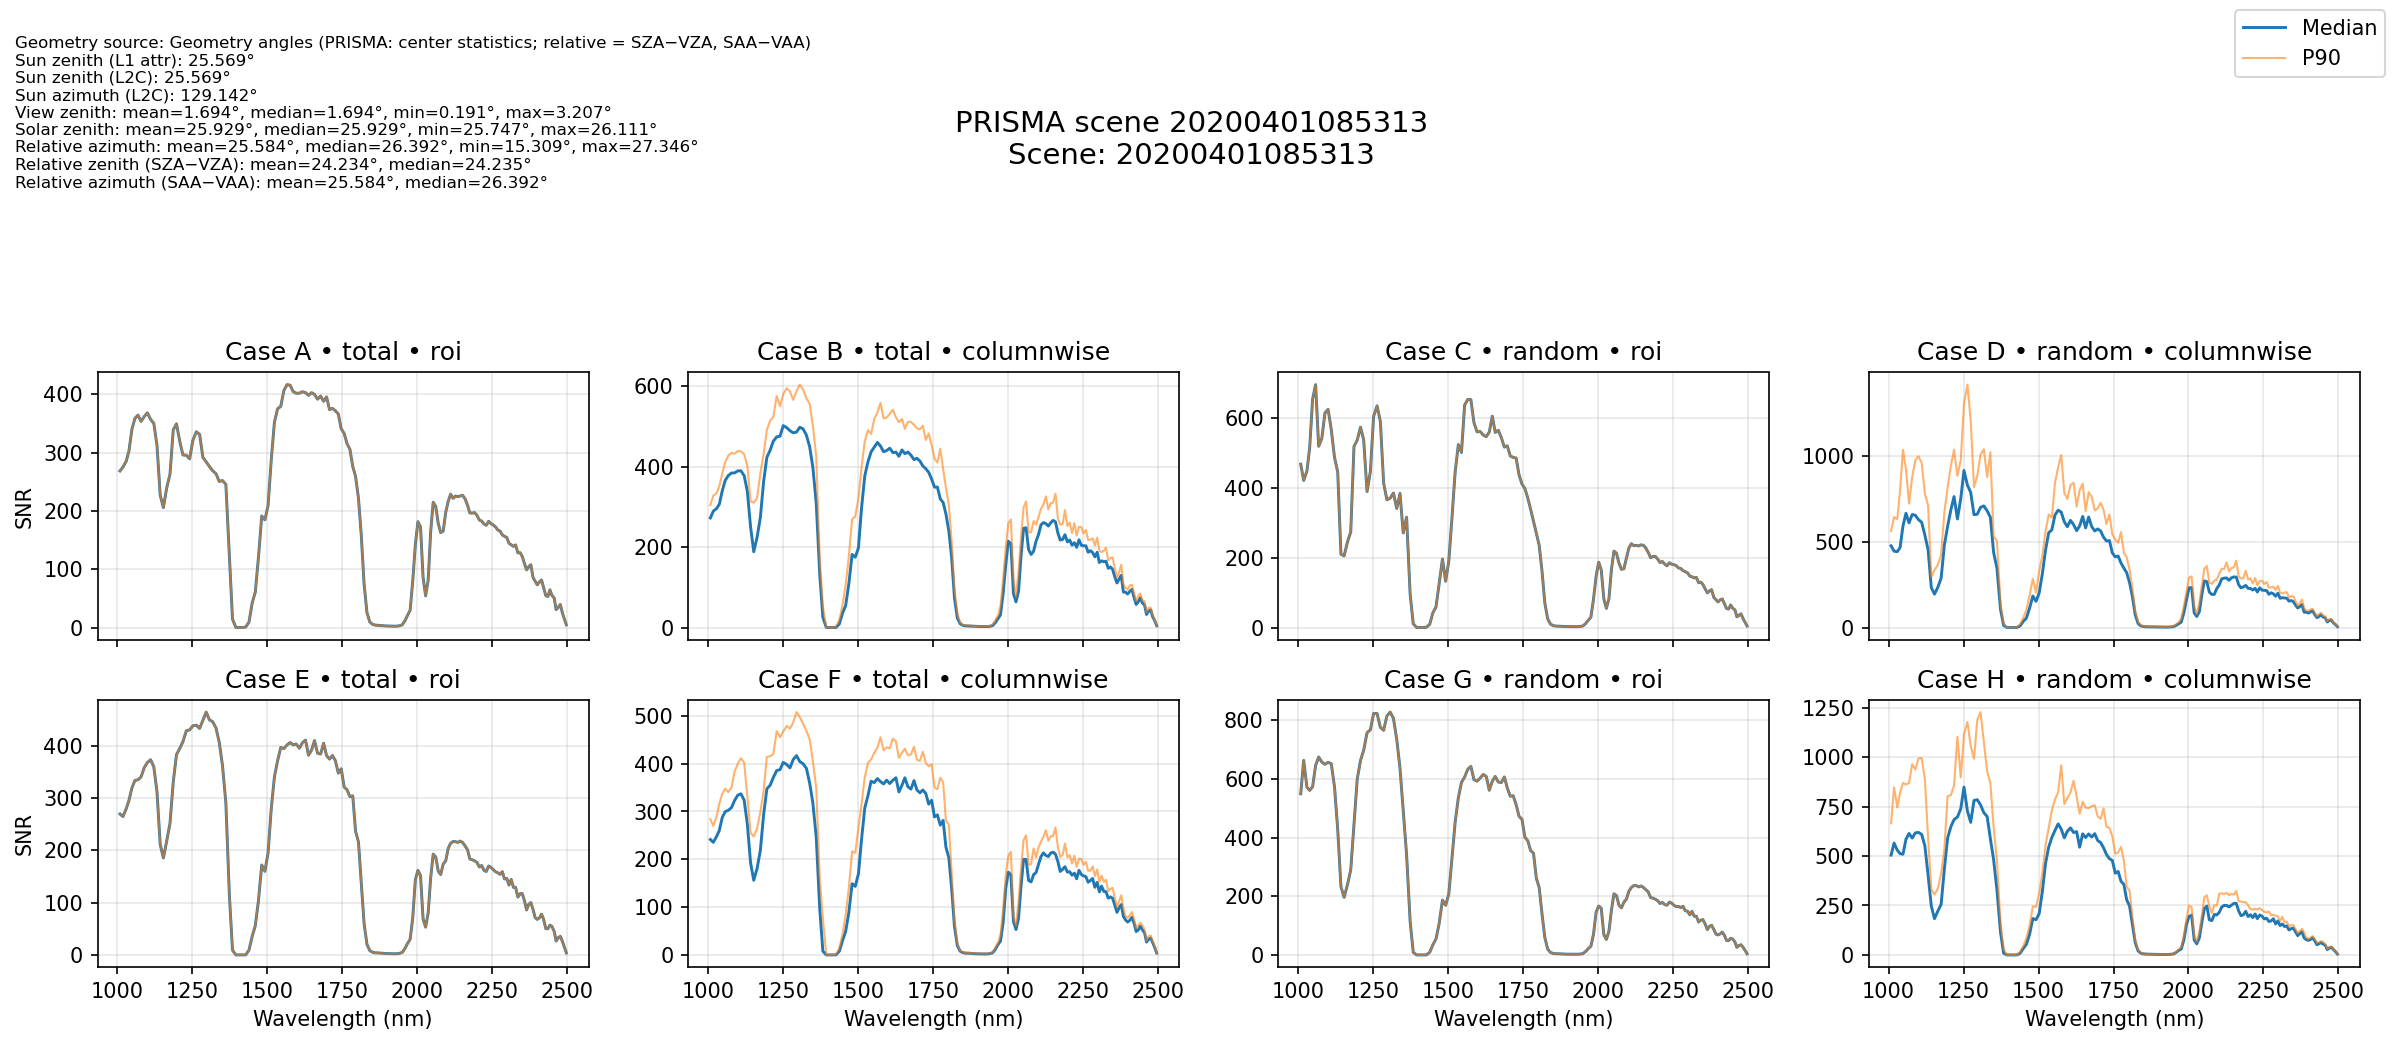

#### Striping diagnostics

**20200401085313 / striping_diagnostics.png**

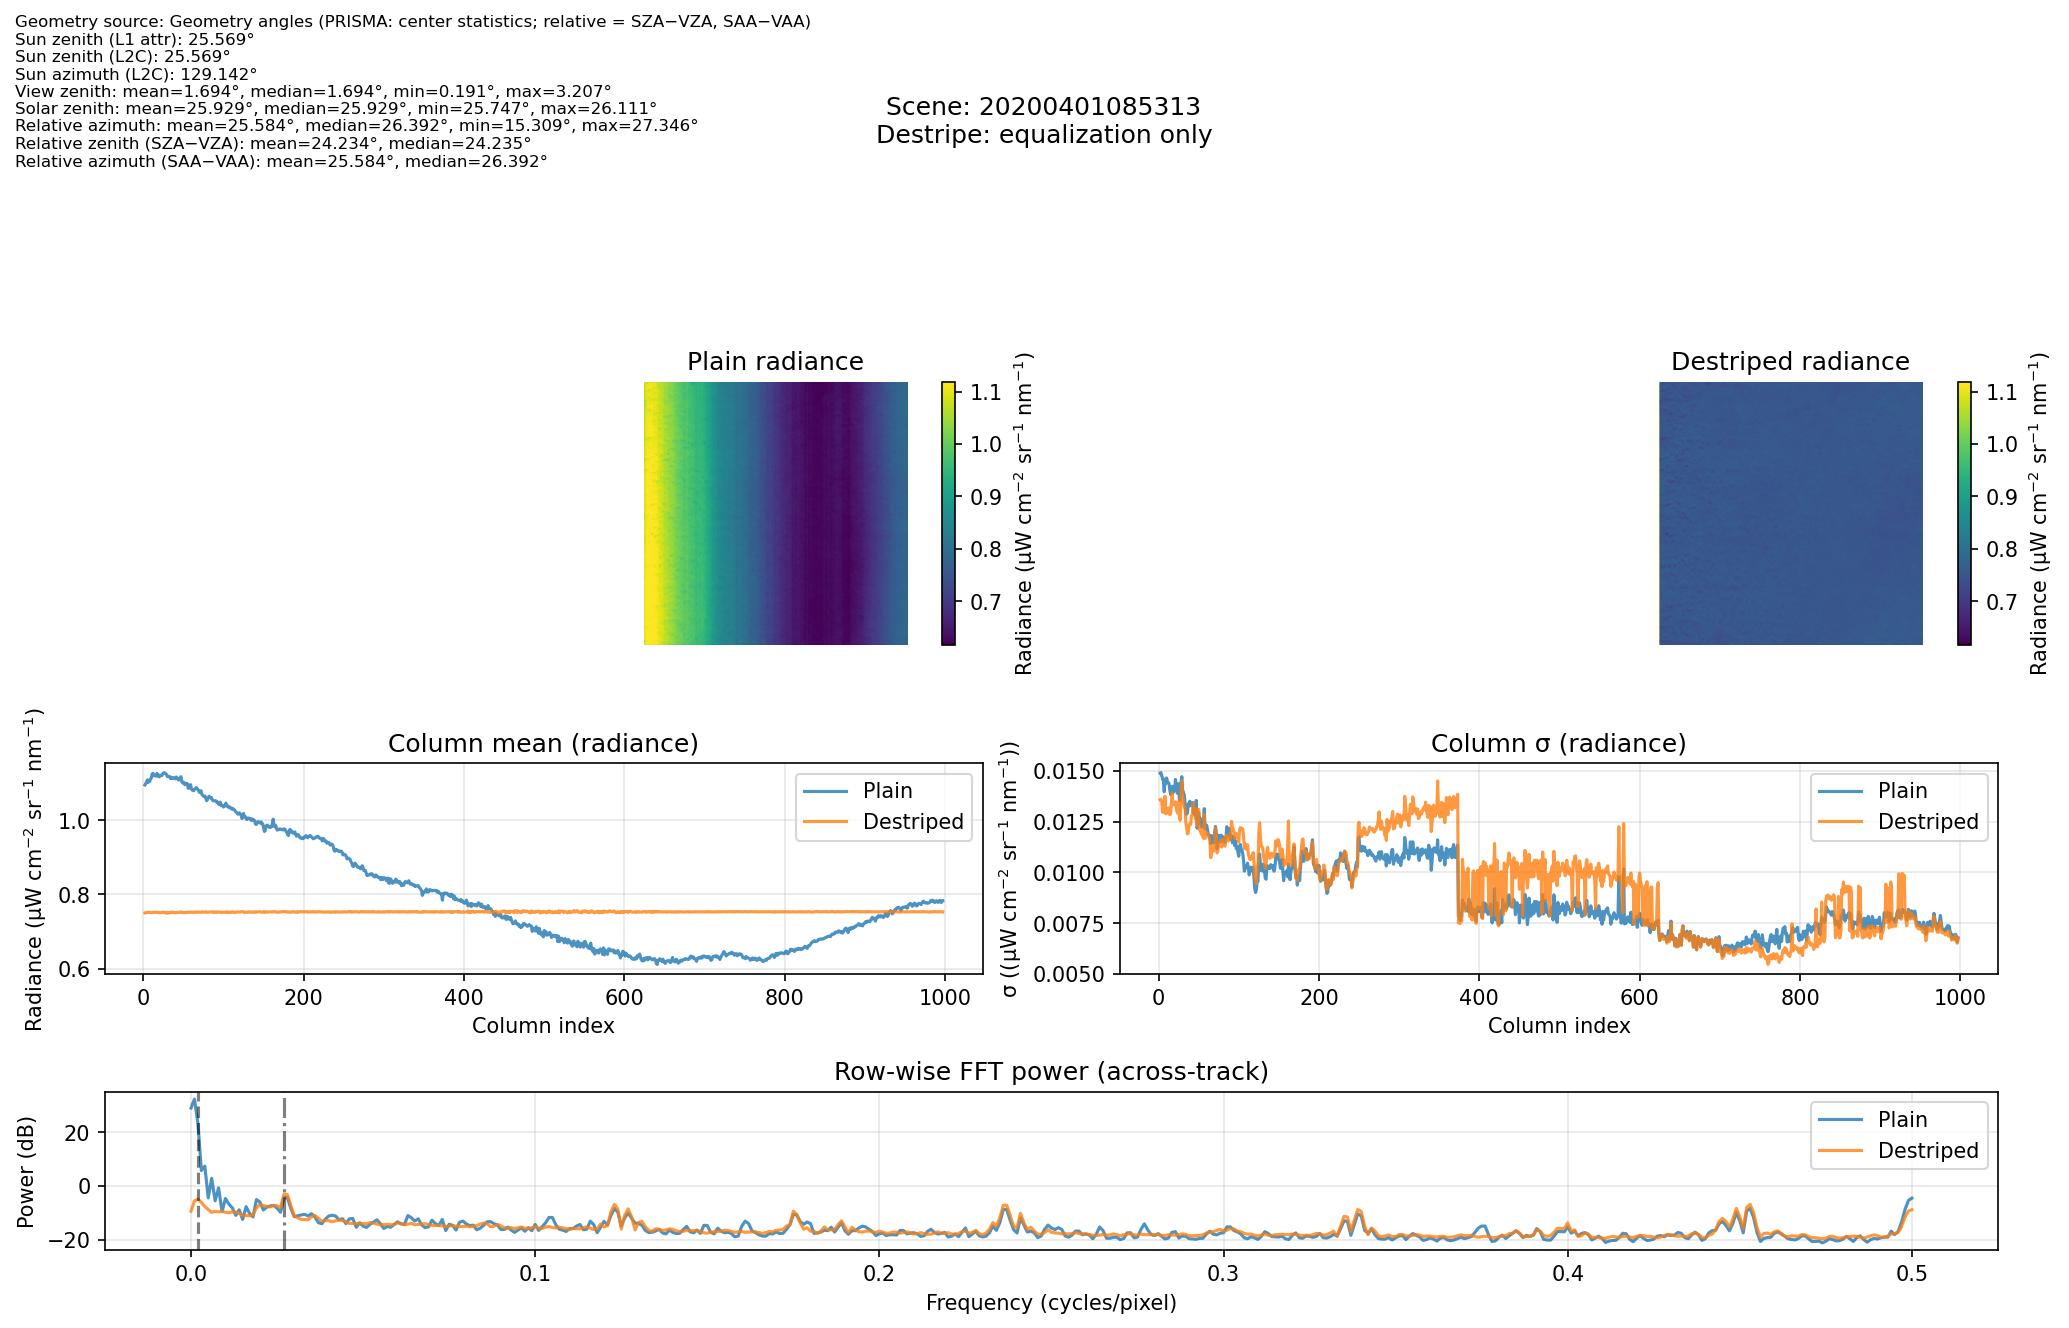

#### PCA summaries

**20200401085313 / pca_summary_destriped.png**

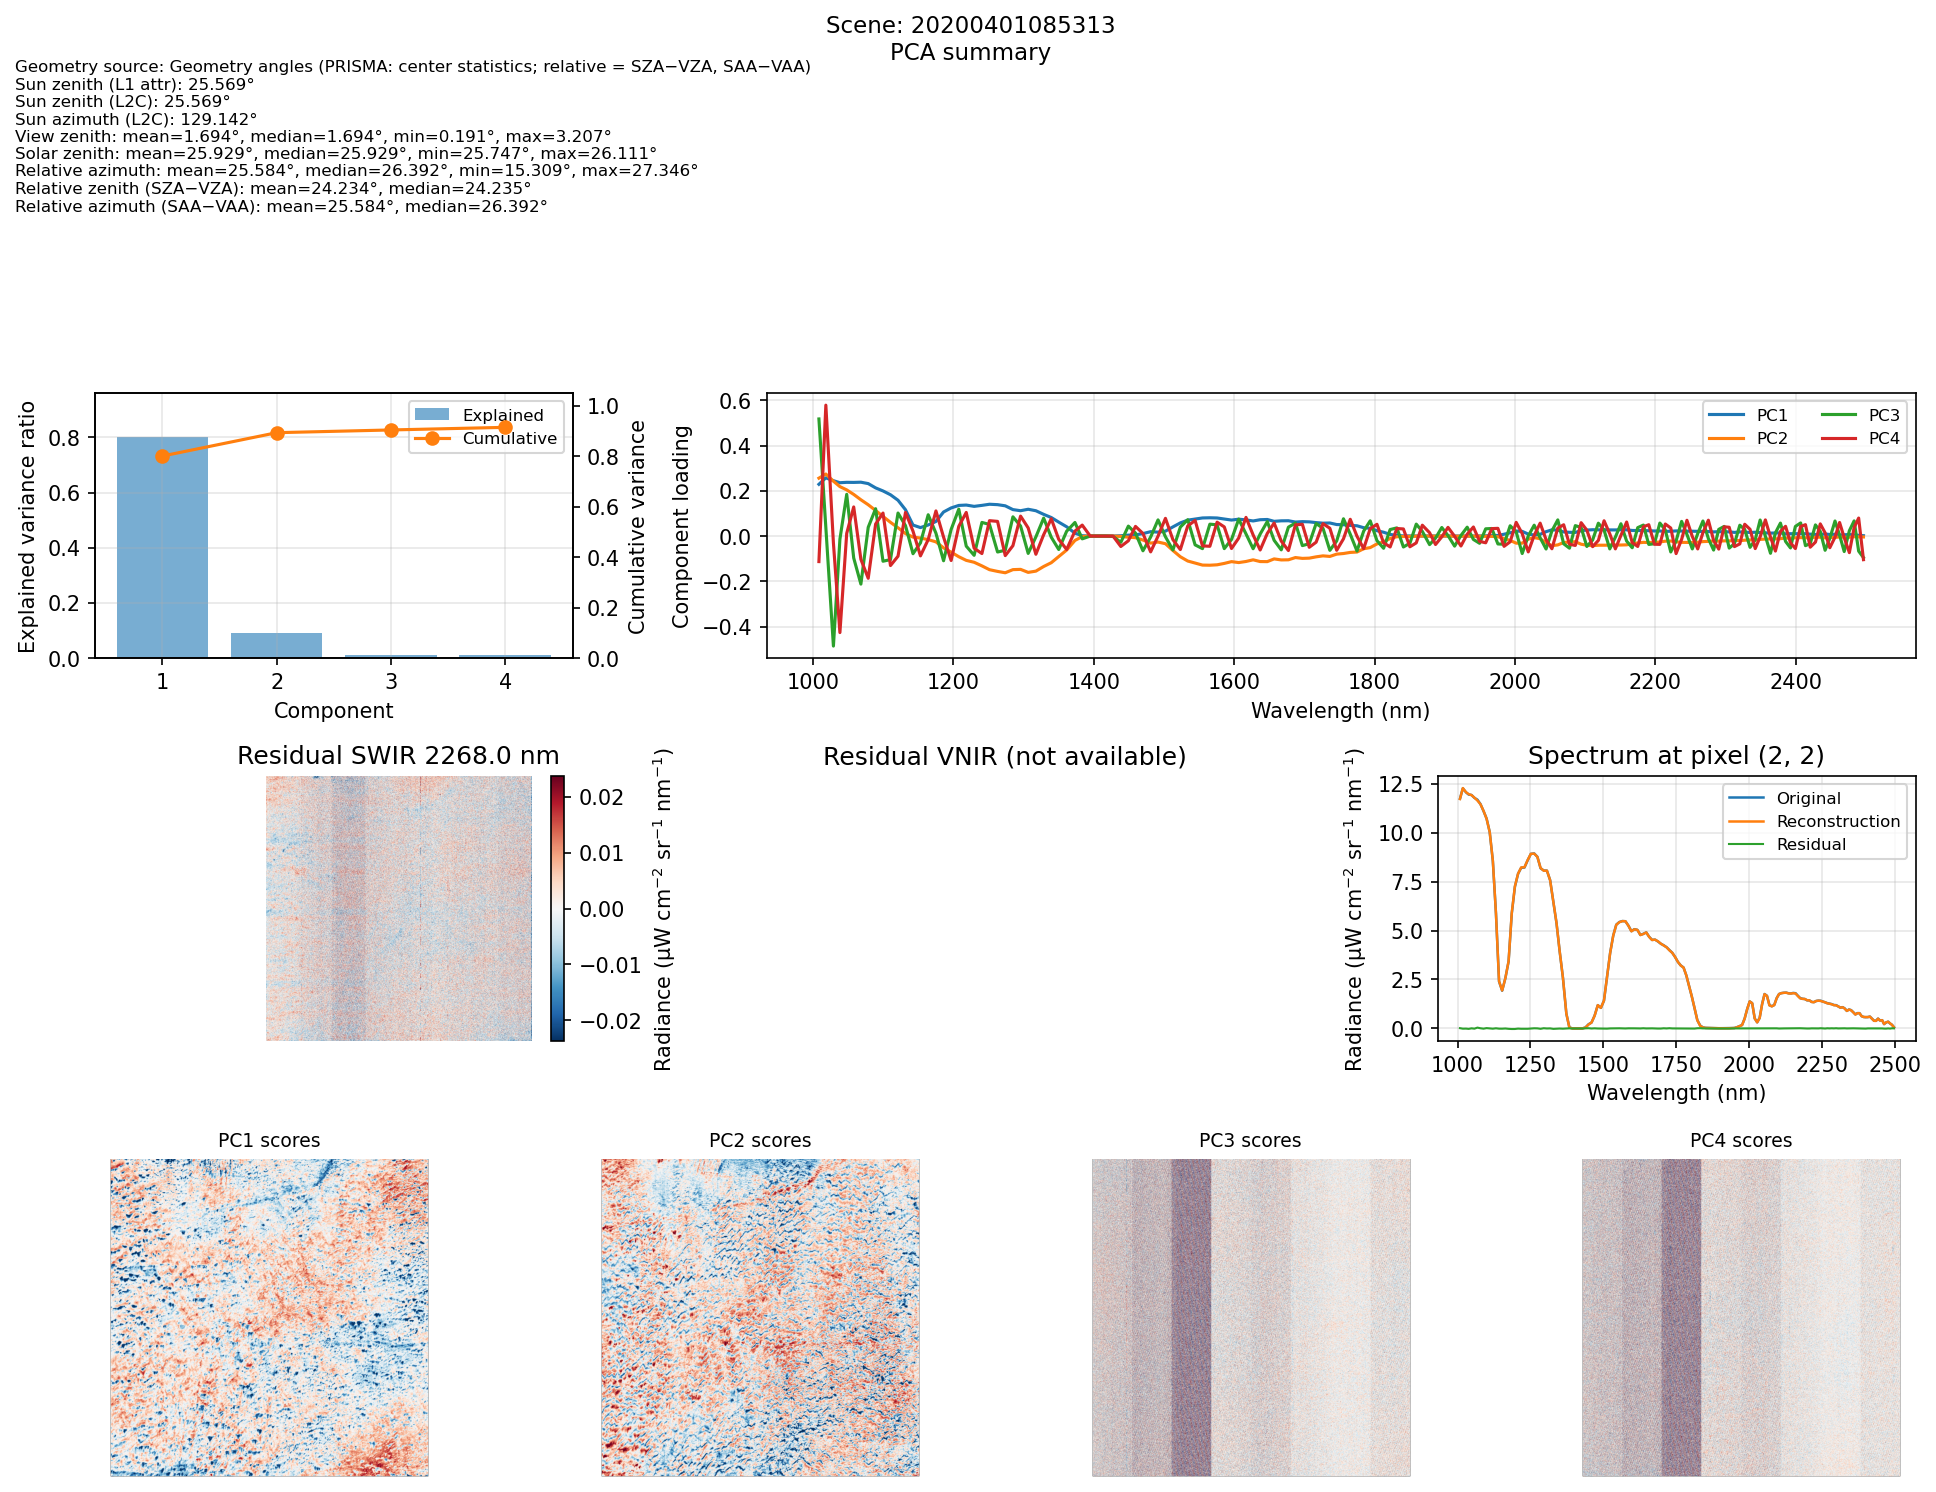

**20200401085313 / pca_summary_plain.png**

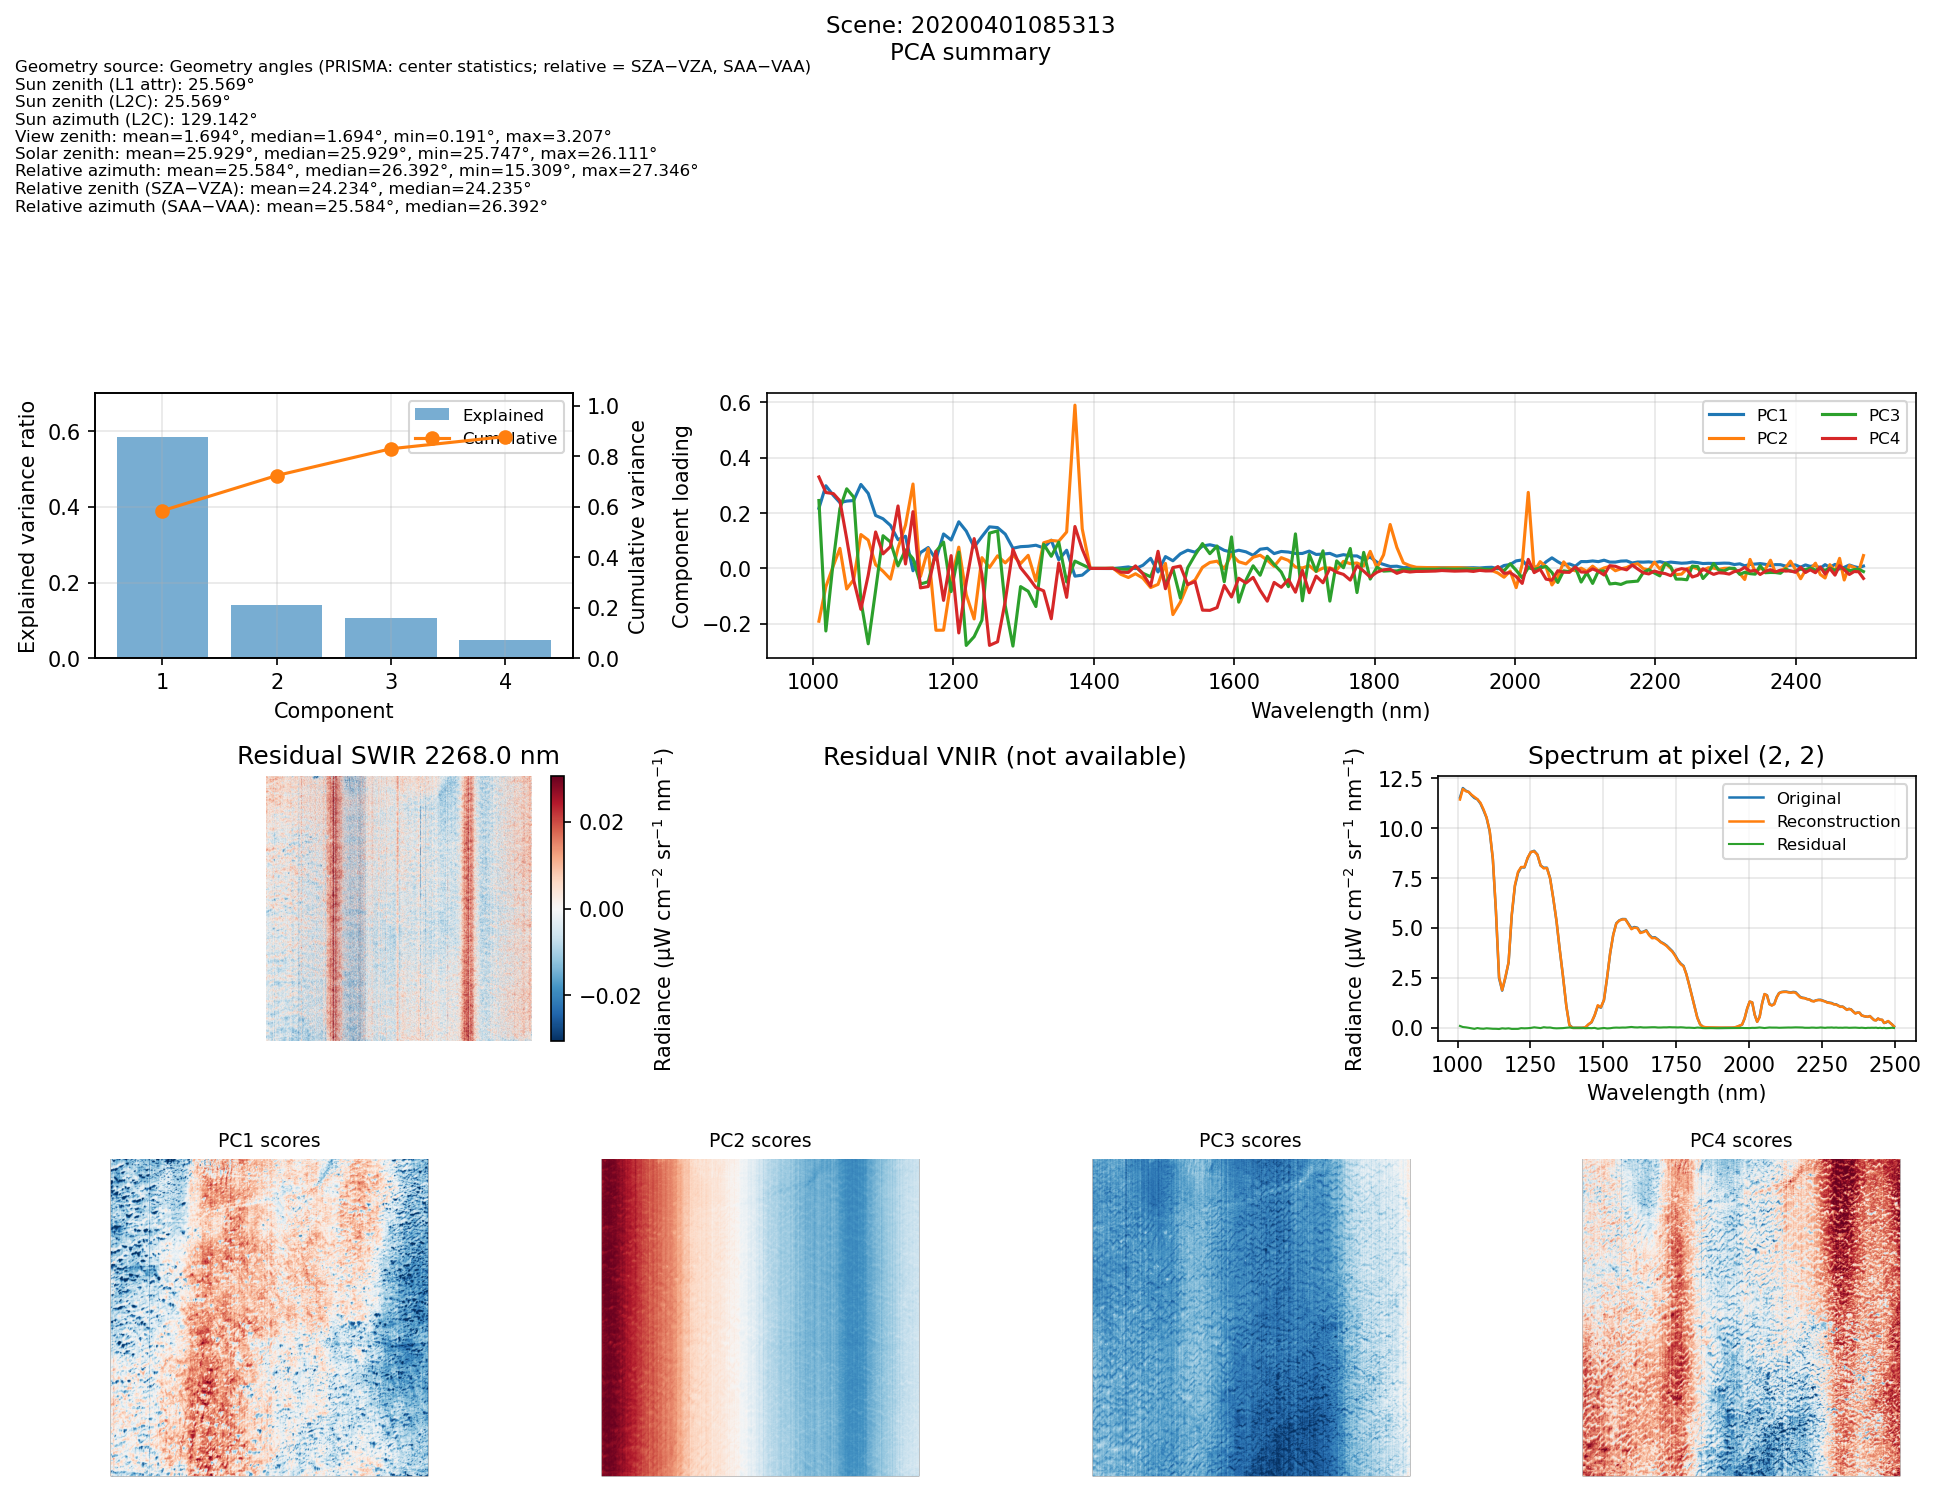

In [5]:
from glob import glob
from IPython.display import Image

output_root = (DEFAULT_OUTDIR / "prisma")
output_root.mkdir(parents=True, exist_ok=True)

if output_root.exists():
    csv_paths = sorted(output_root.glob("**/snr_cases_*.csv"))
    overview_pngs = sorted(output_root.glob("**/snr_cases_overview.png"))
    striping_pngs = sorted(output_root.glob("**/striping_diagnostics.png"))
    pca_pngs = sorted(output_root.glob("**/pca_summary_*.png"))

    display(Markdown(
        f"Found {len(csv_paths)} CSV files, {len(overview_pngs)} SNR overview plots, "
        f"{len(striping_pngs)} striping diagnostics, and {len(pca_pngs)} PCA summaries."
    ))

    if overview_pngs:
        display(Markdown("#### SNR overview"))
        for png in overview_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if striping_pngs:
        display(Markdown("#### Striping diagnostics"))
        for png in striping_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))

    if pca_pngs:
        display(Markdown("#### PCA summaries"))
        for png in pca_pngs:
            display(Markdown(f"**{png.parent.relative_to(output_root)} / {png.name}**"))
            display(Image(filename=str(png)))
else:
    display(Markdown("`outputs/prisma` directory not found yet. Run at least one experiment."))
